<a href="https://colab.research.google.com/github/takao8/MLTSAProject/blob/master/NEPOOL_Data_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import os
import xlrd
import numpy as np
import pandas as pd
import pylab as pl
from urllib.request import urlopen
from statsmodels.graphics.api import qqplot
from tabulate import tabulate

%pylab inline
pl.style.use("https://raw.githubusercontent.com/fedhere/MLTSA_FBianco/master/fbb.mplstyle")

Populating the interactive namespace from numpy and matplotlib


In [9]:
!pip install fbprophet

In [0]:
from sklearn.decomposition import PCA

import fbprophet
from fbprophet import Prophet
from fbprophet import diagnostics

import pickle

# NEPOOL Data Collection and Exploration

In [0]:
nepool = pd.read_excel('https://github.com/takao8/MLTSAProject/blob/master/data/PJM_NEPOOL_hourly_data_Jan2000_Jul2019.xlsx?raw=true')  #stat

In [12]:
nepool.shape

(171562, 19)

In [0]:
# rounding everything to the nearest hour, since some values are a little off
nepool['Date'] = pd.to_datetime(nepool['Date']).dt.round('H')
nepool.set_index("Date", inplace=True)
nepool = nepool[["Nepool_Load_Hist", "KBOS_HID_HIST"]]

In [14]:
nepool.shape

(171562, 2)

In [15]:
nepool.head()

,Nepool_Load_Hist,KBOS_HID_HIST
Date,,
2000-01-01 14:00:00,12849.0,47
2000-01-01 15:00:00,12513.0,45
2000-01-01 16:00:00,12531.0,43
2000-01-01 17:00:00,13706.0,41
2000-01-01 18:00:00,15016.0,40


In [16]:
nepool.describe()

,Nepool_Load_Hist,KBOS_HID_HIST
count,171523.000000,171562.000000
mean,14513.079614,51.308815
std,2824.504439,18.141742
min,7792.000000,-12.000000
25%,12395.370000,38.000000
50%,14531.330000,50.000000
75%,16268.025000,66.000000
max,27622.000000,108.000000


findfont: Font family ['["sans-serif"]'] not found. Falling back to DejaVu Sans.
findfont: Font family ['["sans-serif"]'] not found. Falling back to DejaVu Sans.


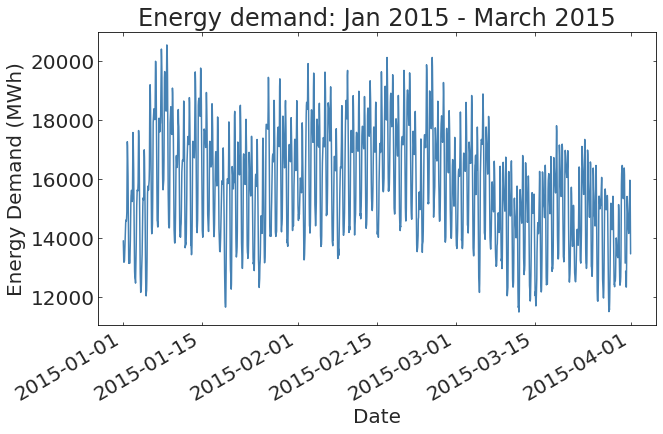

In [17]:
nepool.loc[(nepool.index > '2015-1-1') & (nepool.index < '2015-4-1')]["Nepool_Load_Hist"].plot()
pl.ylabel("Energy Demand (MWh)")
pl.title("Energy demand: Jan 2015 - March 2015");

## Summary

We'll be looking at a load graph.  In this circumstance, load is energy demand, the amount of energy that's consumed at a single point, and NEPOOL is what New England's energy grid is called.  We'll use the column Nepool_Load_Hist, which will show New England's energy consumption from the last 20 years.

There are four main types of seasonalities in this data:


*   Yearly: Energy demand is higher in the Summer/Winter as people turn on their heating or AC, and lower in Spring/Fall.
*   Weekly: Energy demand is higher on the weekdays as businesses and industry are running.
*   Daily: Energy demand is lower at night, and higher as the day starts and continues.
*   Seasonally: The daily energy demand looks different whether it's summer or winter.



## Yearly

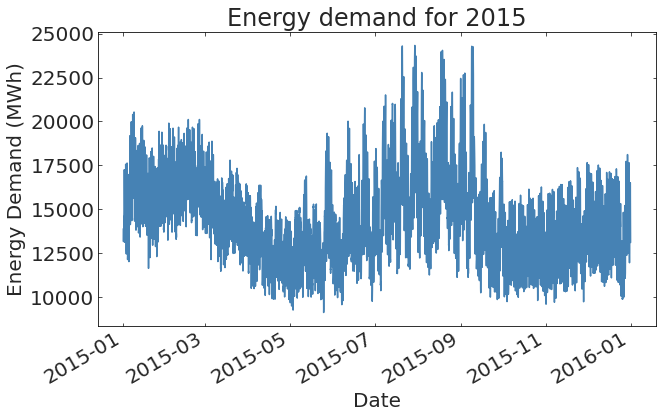

In [18]:
nepool.loc[(nepool.index > '2015-1-1') & (nepool.index < '2016-1-1')]["Nepool_Load_Hist"].plot()
pl.ylabel("Energy Demand (MWh)")
pl.title("Energy demand for 2015");

## Weekly

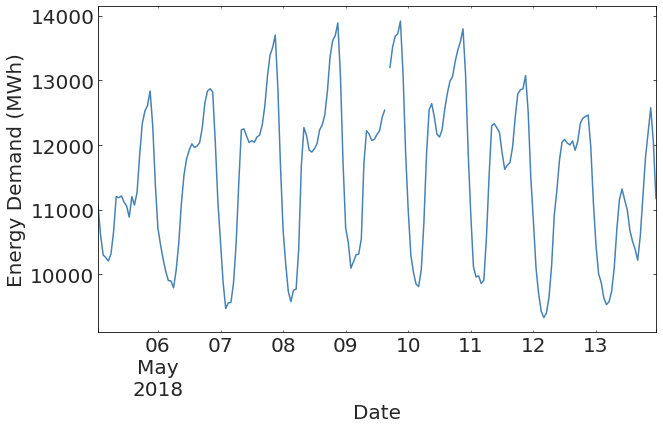

In [19]:
nepool.loc[(nepool.index > '2018-5-05') & (nepool.index < '2018-5-14')]["Nepool_Load_Hist"].plot()
pl.ylabel("Energy Demand (MWh)");

Note that the ticks indicate midnight, so our data starts at 12AM on May 5th, 2018

Note also May 7th = Monday, so we can see a sharp increase in energy demand starting on the 7th, which decreases back to lows on the 12th.

## Daily

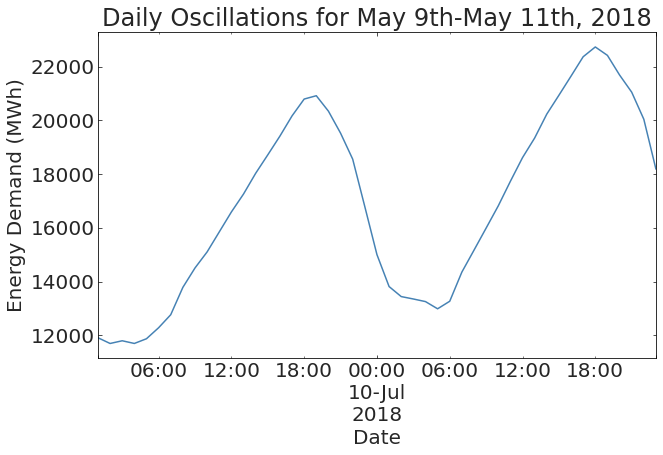

In [20]:
nepool.loc[(nepool.index > '2018-7-09') & (nepool.index < '2018-7-11')]["Nepool_Load_Hist"].plot()
pl.ylabel("Energy Demand (MWh)")
pl.title("Daily Oscillations for May 9th-May 11th, 2018");

So energy usage will (typically) peak around 6pm, decease through the night, and increase through the morning.

## Seasonal

The graph above was a good example for what energy usage looks like in the summer.

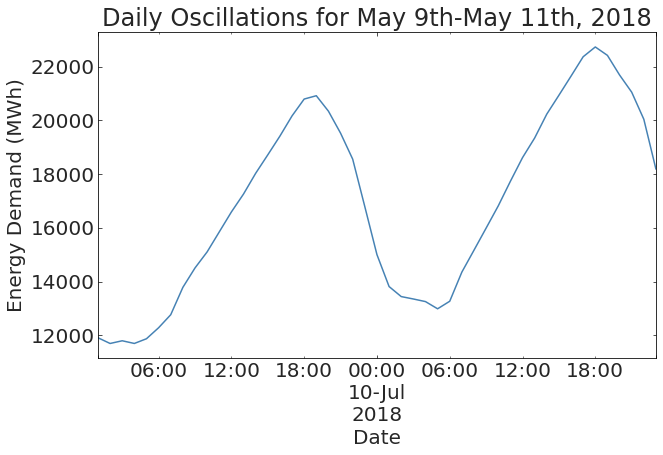

In [21]:
nepool.loc[(nepool.index > '2018-7-09') & (nepool.index < '2018-7-11')]["Nepool_Load_Hist"].plot()
pl.ylabel("Energy Demand (MWh)")
pl.title("Daily Oscillations for May 9th-May 11th, 2018");

In winter, there's a double peak:

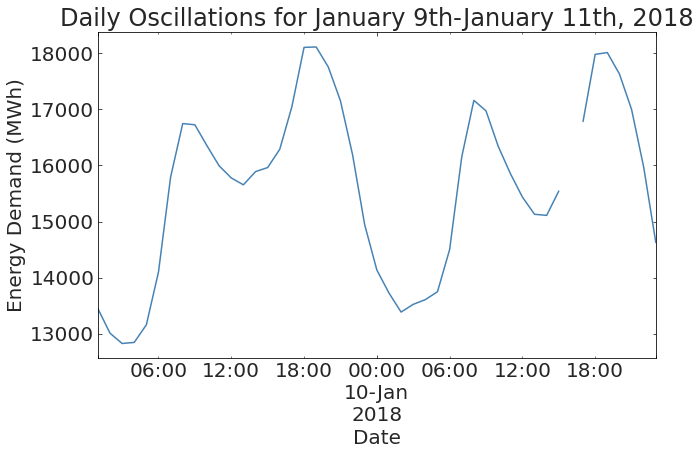

In [22]:
nepool.loc[(nepool.index > '2018-1-09') & (nepool.index < '2018-1-11')]["Nepool_Load_Hist"].plot()
pl.ylabel("Energy Demand (MWh)")
pl.title("Daily Oscillations for January 9th-January 11th, 2018");

Which could be explained by people turning their heat off when they leave to work.  

Note also that holidays act similar to weekends, decreasing the energy demand as businesses and industry close for the day.

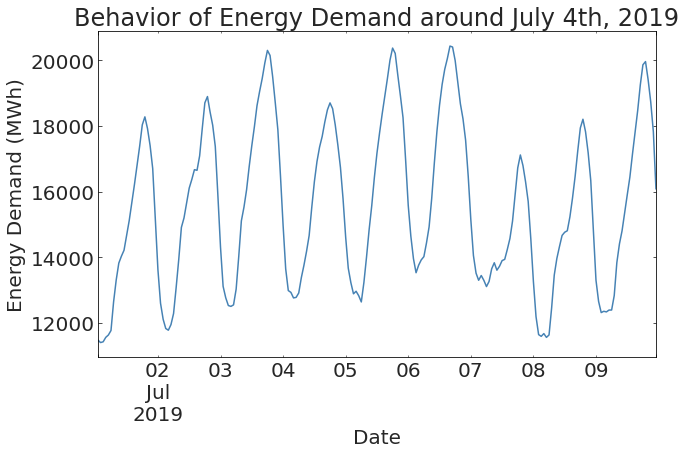

In [23]:
nepool.loc[(nepool.index < '2019-7-10') & (nepool.index > '2019-7-1')]["Nepool_Load_Hist"].plot()
pl.ylabel("Energy Demand (MWh)")
pl.title("Behavior of Energy Demand around July 4th, 2019");

## Final Notes

Overall, load doesn't behave too erratically, so it should be overall pretty easy to do some forecasting and check that our forecasting isn't overfit.  There's a lot of subproblems we can branch to if we don't think this is enough for the project, but we can decide that down the line.  Other notes:


*   Fall and Spring look like a transition between winter and summer--their load graphs are inbetween a double peak and a single peak
*   Weather intuitively has a strong correlation with energy usage, thus are great variables to use when forecasting future energy demand.
*   The other variables in the data (such as KBOS_HID_HIST) are temperature data.  The KBOS is the airport code, and indicates it's Loan Airport, just as KPHL indicates Philadelphia International


One last graph that's nice to look at is Temperature vs Energy Demand, which makes a U shape.  These are commonly used to show forecasting results.  Notice that at the ends (colder temperature and hotter temperature), energy demand curves up, as we would expect.

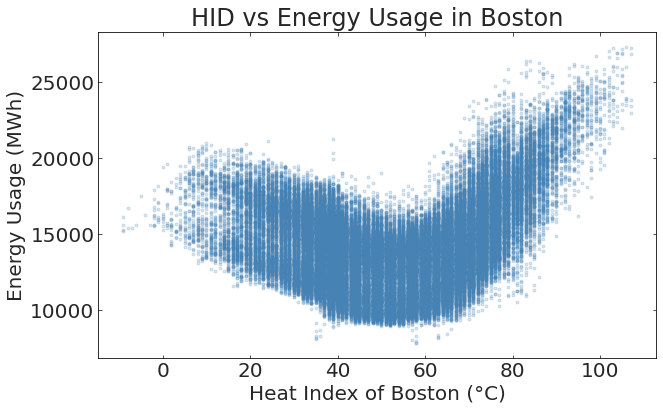

In [24]:
pl.plot(nepool['KBOS_HID_HIST'][100000:], nepool['Nepool_Load_Hist'][100000:], '.', alpha=0.2)
pl.xlabel('Heat Index of Boston (°C)')
pl.ylabel('Energy Usage (MWh)')
pl.title('HID vs Energy Usage in Boston');

# Use NOAA to get historical **hourly** weather information for Boston, MA

NOAA provides data much further back in history. Both daily and hourly data is available.

In [25]:
# Grab datasets
noaa_hourly_1 = pd.read_csv('https://raw.githubusercontent.com/takao8/MLTSAProject/master/data/boston_weather_hourly_1.csv')
noaa_hourly_2 = pd.read_csv('https://raw.githubusercontent.com/takao8/MLTSAProject/master/data/boston_weather_hourly_2.csv')

# Concatenate datasets
weather_noaa = pd.concat([noaa_hourly_1, noaa_hourly_2])
print(weather_noaa.shape)

# Make the index of the new dataframe the date
weather_noaa.index = pd.to_datetime(weather_noaa.DATE).dt.round('H')
weather_noaa.drop(columns=['DATE'], inplace=True)

# Drop all columns that are NaN in more than half of the rows
weather_noaa.dropna(axis=1, thresh=len(weather_noaa)/2, inplace=True)     # This drops the total columns from 123 to 28

# Keep only the columns that contain hourly information
columns = list(filter(lambda x : 'Hourly' in x, weather_noaa.columns))
columns.remove('HourlySkyConditions')  
columns.remove('HourlyVisibility')
columns.remove('HourlyWindDirection')
columns.remove('HourlyStationPressure')                                   # Column count now drops to 9

weather_noaa = weather_noaa[columns]
weather_noaa.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (3,19,25,26,27,28,29,30,31,33,34,35,36,41,42,43,46,48,49,51,52,53,56,58,59,61,63,69,71,73,75,76,77,82,88,89,95,96,97,98,99,100,101,102,103,104,105,106,107,110,111,112,113,114,115,116,117,118,119) have mixed types.Specify dtype option on import or set low_memory=False.

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (41,42,43,46,49,51,75,89) have mixed types.Specify dtype option on import or set low_memory=False.



(299592, 124)


,HourlyAltimeterSetting,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyRelativeHumidity,HourlySeaLevelPressure,HourlyWetBulbTemperature,HourlyWindSpeed
DATE,,,,,,,,
2000-01-01 00:00:00,30.18,18,28,0.00,66,30.17,NaN,8
2000-01-01 01:00:00,30.18,18,27,NaN,69,30.18,NaN,6
2000-01-01 01:00:00,30.18,17,27,0.00,66,30.18,24,6
2000-01-01 02:00:00,30.19,18,32,0.00,56,30.19,NaN,10
2000-01-01 03:00:00,30.22,19,30,0.00,64,30.21,NaN,8


In [26]:
print('Available column names:', *weather_noaa.columns, sep='\n-')

Available column names:
-HourlyAltimeterSetting
-HourlyDewPointTemperature
-HourlyDryBulbTemperature
-HourlyPrecipitation
-HourlyRelativeHumidity
-HourlySeaLevelPressure
-HourlyWetBulbTemperature
-HourlyWindSpeed


In [0]:
def change(elem):
    if type(elem) == str:
        try:
            # Attempt to convert the string to a float directly
            elem.astype(elem)
        except:
            try:
                # Remove all non-numeric characters and convert to a float
                elem = float(''.join(filter(lambda x: x in '0123456789.', elem)))
            except:
                # All characters were non-numeric, so the value is not a valid number
                #print('failed', elem)
                elem = NaN
    return elem

Some of the data is horrible. Some values have a random 's' after the number. Other values are not available and have a string in their place ('*', 'T', 'VRB'). The data must be cleaned before it can be used.

In [0]:
for col in columns:
    weather_noaa[col] = weather_noaa[col].apply(lambda x : change(x))

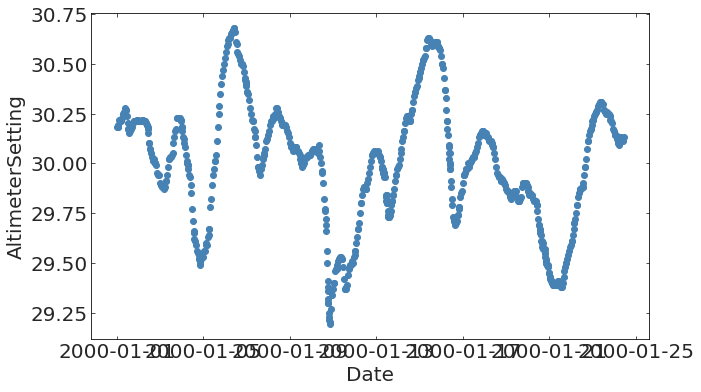

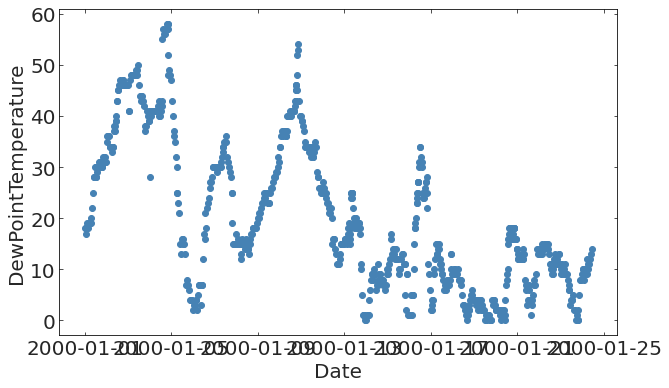

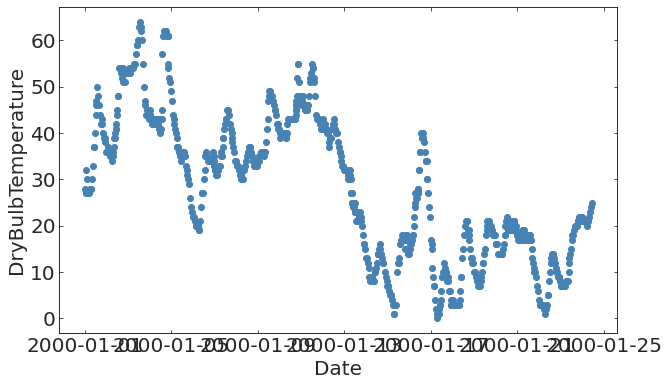

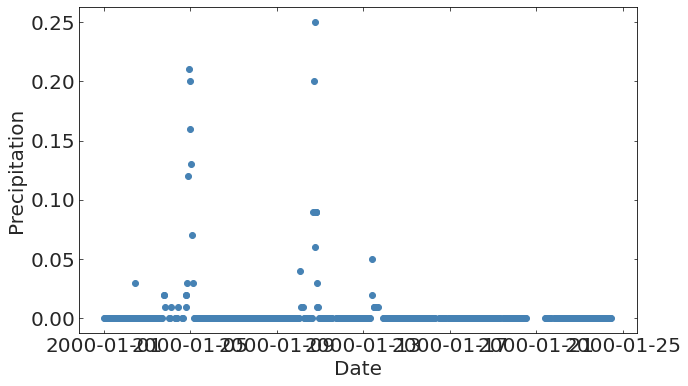

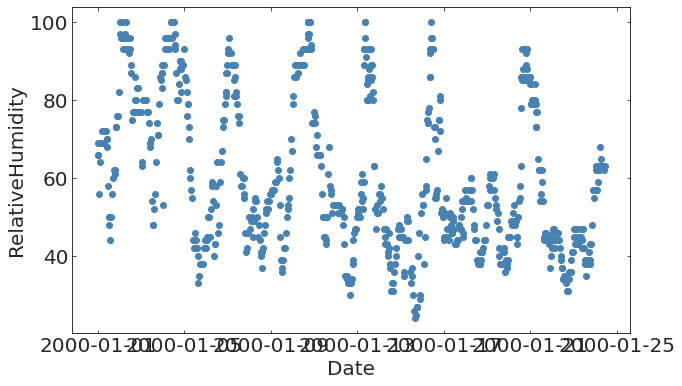

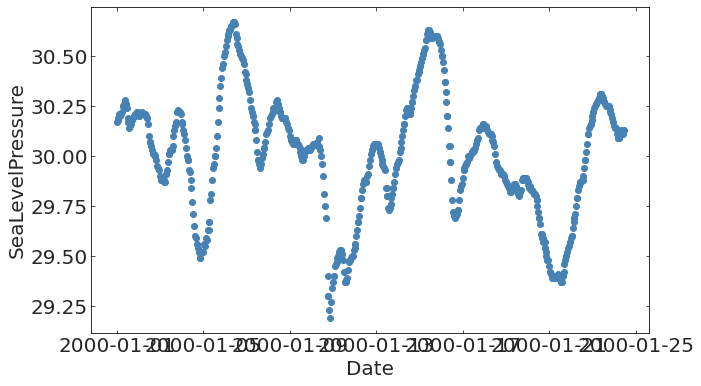

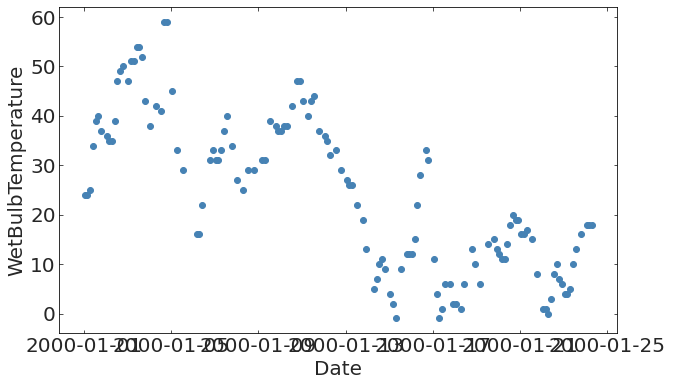

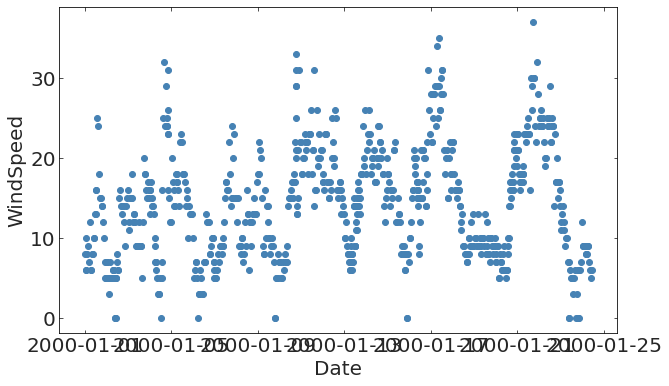

<Figure size 720x432 with 0 Axes>

In [29]:
for col in weather_noaa.columns:
    pl.scatter(weather_noaa.index[:1000], weather_noaa[col][:1000])
    pl.xlabel('Date')
    pl.ylabel(col[6:])
    pl.figure();

In [30]:
weather_noaa.describe()

,HourlyAltimeterSetting,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyRelativeHumidity,HourlySeaLevelPressure,HourlyWetBulbTemperature,HourlyWindSpeed
count,218977.000000,258807.000000,258840.000000,169515.000000,258801.000000,223762.000000,214281.000000,258962.000000
mean,29.979441,41.072823,51.725344,0.012418,69.526234,29.996189,47.131566,10.977726
std,0.259816,18.557110,17.442151,0.173460,20.155942,0.252950,16.109381,7.100306
min,28.730000,-24.000000,-8.000000,0.000000,9.000000,28.720000,-10.000000,0.000000
25%,29.820000,28.000000,38.000000,0.000000,54.000000,29.840000,35.000000,7.000000
50%,29.990000,43.000000,52.000000,0.000000,71.000000,30.000000,48.000000,10.000000
75%,30.150000,57.000000,66.000000,0.000000,87.000000,30.160000,61.000000,14.000000
max,30.880000,79.000000,102.000000,10.070000,100.000000,30.870000,81.000000,2237.000000


In [31]:
weather_noaa.shape

(299592, 8)

In [0]:
weather_noaa.to_csv('boston_weather_cleaned.csv')